In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")
sns.set_palette("bright")
from warnings import filterwarnings
filterwarnings("ignore")
import os

In [28]:
df = pd.read_csv("C:\\Users\\SARVESH SURVE\\OneDrive\\Desktop\\data\\Kaggle data set\\Market.csv",sep=';')

In [29]:
df.head()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,01.12.2010 08:26,"2,55",17850.0,United Kingdom
1,536365,WHITE METAL LANTERN,6,01.12.2010 08:26,"3,39",17850.0,United Kingdom
2,536365,CREAM CUPID HEARTS COAT HANGER,8,01.12.2010 08:26,"2,75",17850.0,United Kingdom
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,01.12.2010 08:26,"3,39",17850.0,United Kingdom
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,01.12.2010 08:26,"3,39",17850.0,United Kingdom


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522064 entries, 0 to 522063
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   BillNo      522064 non-null  object 
 1   Itemname    520609 non-null  object 
 2   Quantity    522064 non-null  int64  
 3   Date        522064 non-null  object 
 4   Price       522064 non-null  object 
 5   CustomerID  388023 non-null  float64
 6   Country     522064 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 27.9+ MB


In [31]:
df["Price"] = df["Price"].str.replace(",",".")
df["Price"] = df["Price"].astype("float64")

In [32]:
df.Date.unique()

array(['01.12.2010 08:26', '01.12.2010 08:28', '01.12.2010 08:34', ...,
       '09.12.2011 12:31', '09.12.2011 12:49', '09.12.2011 12:50'],
      dtype=object)

**The newest date is 9.12.2011. Let's assume that today is 01.01.2012**

In [33]:
today = "2012-01-01"
today = pd.to_datetime(today)
df["Date"] = pd.to_datetime(df["Date"])

# RFM ANALYSIS

Now, we'are going to analyze customers' recencies, frequencies and monetaries then cluster them.

R = Recency F = Frequency M = Monetary

# Recency

In [34]:
rec_table = df.groupby(["CustomerID"]).agg({"Date": lambda x: ((today - x.max()).days)})
rec_table.columns = ["Recency"]

In [35]:
rec_table.head()

,Recency
CustomerID,
12346.0,347
12347.0,61
12349.0,40
12350.0,332
12352.0,94


# Frequency

In [36]:
freq_table = df.drop_duplicates(subset = "BillNo").groupby(["CustomerID"])[["BillNo"]].count()
freq_table.columns = ["Frequency"]
freq_table.head()

,Frequency
CustomerID,
12346.0,1
12347.0,7
12349.0,1
12350.0,1
12352.0,8


# Monetary

In [37]:
df["Total_Price"] = df["Quantity"] * df["Price"]

In [38]:
monetary_table = df.groupby(["CustomerID"])[["Total_Price"]].sum()
monetary_table.columns = ["Monetary"]
monetary_table.head()

,Monetary
CustomerID,
12346.0,77183.60
12347.0,4310.00
12349.0,1757.55
12350.0,334.40
12352.0,2506.04


In [39]:
rfm_data = pd.concat([rec_table, freq_table, monetary_table], axis = 1)
rfm_data.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,347,1,77183.60
12347.0,61,7,4310.00
12349.0,40,1,1757.55
12350.0,332,1,334.40
12352.0,94,8,2506.04


In [41]:
rfm_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,4297.0,126.545264,115.234387,21.0,43.00,82.00,183.00,718.00
Frequency,4297.0,4.227368,7.091298,1.0,1.00,2.00,5.00,210.00
Monetary,4297.0,1993.140888,8588.143093,0.0,306.72,668.58,1652.58,280206.02


**Scaling the data for clustering.**

In [42]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data)

Let's determine a cluster number

In [46]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
score=[]
K=range(1,6)

for i in K:
    kmeans=KMeans(n_clusters=i,init="k-means++",random_state=0)
    kmeans.fit(rfm_scaled)
    score.append(kmeans.inertia_)

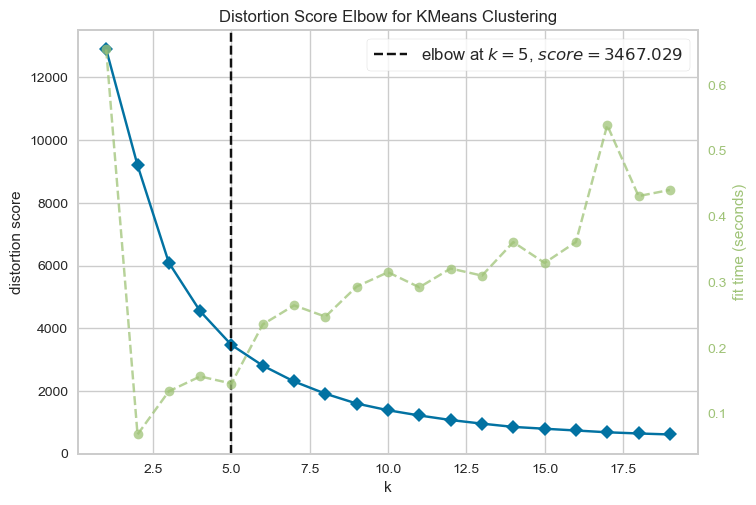

In [47]:
kmeans=KMeans()
visu=KElbowVisualizer(kmeans,k=(1,20))   
visu.fit(rfm_scaled)
visu.poof();

Best cluster number is 5. Let's create a clustering model

In [48]:
kmeans = KMeans(n_clusters = 5)
kmeans.fit(rfm_scaled)
rfm_data["Cluster_No"] = (kmeans.labels_ + 1)

In [49]:
rfm_data.head()

,Recency,Frequency,Monetary,Cluster_No
CustomerID,,,,
12346.0,347,1,77183.60,4
12347.0,61,7,4310.00,1
12349.0,40,1,1757.55,1
12350.0,332,1,334.40,2
12352.0,94,8,2506.04,1


# Analyzing of Clustering

In [50]:
rfm_data.groupby(["Cluster_No"])[["Recency", "Frequency", "Monetary"]].mean()

,Recency,Frequency,Monetary
Cluster_No,,,
1,75.215363,3.305507,1187.811811
2,290.414972,1.536969,487.542607
3,31.263158,69.947368,44816.476842
4,41.961765,16.311765,8150.704765
5,47.200000,40.600000,205560.228000


Hmm. Our model determine 5 clusters that

* **Cluster 1/2/4 -->** Customers who haven't been here in a long time. We need to do some discount for them. We can still turn them back.
* **Cluster 3 -->** Middle-level customers.
* **Cluster 5 -->** Premium customers. We don't want to lose them. They spend a lot of money for us, and their recency is good

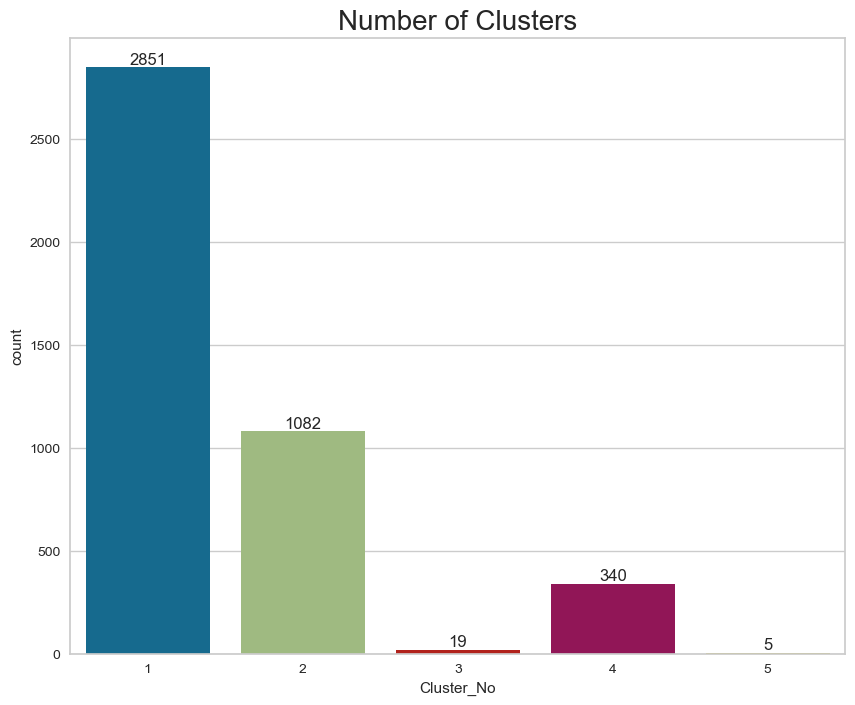

In [52]:
plt.figure(figsize = (10,8))
ax = sns.countplot(rfm_data.Cluster_No)
plt.title("Number of Clusters", fontsize = 20);
for bars in ax.containers:
    ax.bar_label(bars)

In [53]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
pca = pca.fit_transform(rfm_scaled)

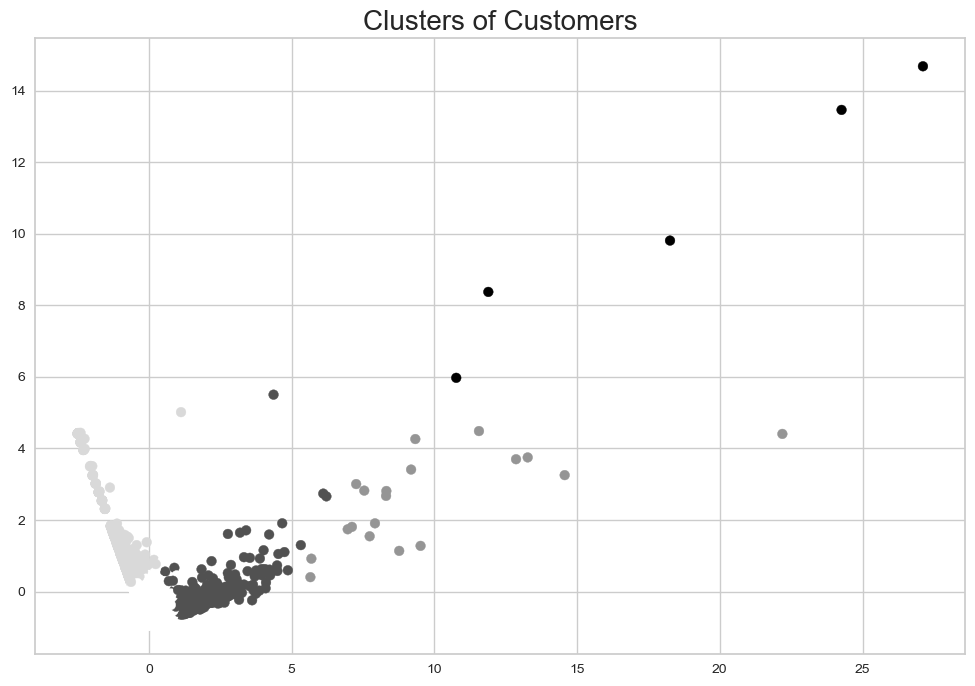

In [54]:
plt.figure(figsize = (12,8))
plt.scatter(pca[:,0], pca[:,1], c = kmeans.labels_)
plt.title("Clusters of Customers", fontsize = 20);

# ASSOCIATION ANALYSIS

**Association analysis** is the task of finding interesting relationships in large datasets. These interesting relationships can take two forms: frequent item sets or association rules. Frequent item sets are a collection of items that frequently occur together. The second way to view interesting relationships is association rules. Association rules suggest that a strong relationship exists between two items.

Now, we will take a look at which items are related to each other.

In [55]:
data_apr = df.groupby(["BillNo", "Itemname"])[["Quantity"]].sum(
).unstack().reset_index().fillna(0).set_index("BillNo")

In [56]:
data_apr.head()

Quantity                                                 \
Itemname *Boombox Ipod Classic *USB Office Mirror Ball 10 COLOUR SPACEBOY PEN   
BillNo                                                                          
536365                     0.0                     0.0                    0.0   
536366                     0.0                     0.0                    0.0   
536367                     0.0                     0.0                    0.0   
536368                     0.0                     0.0                    0.0   
536369                     0.0                     0.0                    0.0   

                                                               \
Itemname 12 COLOURED PARTY BALLOONS 12 DAISY PEGS IN WOOD BOX   
BillNo                                                          
536365                          0.0                       0.0   
536366                          0.0                       0.0   
536367                          0.0                       0.0   
536368                          0.0                       0.0   
536369                          0.0                       0.0   

                                                                 \
Itemname 12 EGG HOUSE PAINTED WOOD 12 HANGING EGGS HAND PAINTED   
BillNo                                                            
536365                         0.0                          0.0   
536366                         0.0                          0.0   
536367                         0.0                          0.0   
536368                         0.0                          0.0   
536369                         0.0                          0.0   

                                                                           \
Itemname 12 IVORY ROSE PEG PLACE SETTINGS 12 MESSAGE CARDS WITH ENVELOPES   
BillNo                                                                      
536365                                0.0                             0.0   
536366                                0.0                             0.0   
536367                                0.0                             0.0   
536368                                0.0                             0.0   
536369                                0.0                             0.0   

                                        ...                      \
Itemname 12 PENCIL SMALL TUBE WOODLAND  ... wrongly coded 20713   
BillNo                                  ...                       
536365                             0.0  ...                 0.0   
536366                             0.0  ...                 0.0   
536367                             0.0  ...                 0.0   
536368                             0.0  ...                 0.0   
536369                             0.0  ...                 0.0   

                                                                 \
Itemname wrongly coded 23343 wrongly coded-23343 wrongly marked   
BillNo                                                            
536365                   0.0                 0.0            0.0   
536366                   0.0                 0.0            0.0   
536367                   0.0                 0.0            0.0   
536368                   0.0                 0.0            0.0   
536369                   0.0                 0.0            0.0   

                                                           \
Itemname wrongly marked 23343 wrongly marked carton 22804   
BillNo                                                      
536365                    0.0                         0.0   
536366                    0.0                         0.0   
536367                    0.0                         0.0   
536368                    0.0                         0.0   
536369                    0.0                         0.0   

                                                                    \
Itemname wrongly marked. 23343 in box wrongly sold (22719) barcod

In [58]:
def num(x):
    if x <= 0:
        return 0
    elif x >=1:
        return 1
basket_new = data_apr.applymap(num)

In [59]:
basket_new.nunique()

          Itemname                    
Quantity  *Boombox Ipod Classic           2
          *USB Office Mirror Ball         2
          10 COLOUR SPACEBOY PEN          2
          12 COLOURED PARTY BALLOONS      2
          12 DAISY PEGS IN WOOD BOX       2
                                         ..
          wrongly marked carton 22804     1
          wrongly marked. 23343 in box    1
          wrongly sold (22719) barcode    2
          wrongly sold as sets            1
          wrongly sold sets               1
Length: 4185, dtype: int64

In [60]:
from mlxtend.frequent_patterns import apriori

apr = apriori(basket_new, min_support = 0.02, use_colnames = True)
apr.sort_values(by = "support", ascending = False)

,support,itemsets
263,0.108956,"((Quantity, WHITE HANGING HEART T-LIGHT HOLDER))"
97,0.102128,"((Quantity, JUMBO BAG RED RETROSPOT))"
190,0.094211,"((Quantity, REGENCY CAKESTAND 3 TIER))"
151,0.081940,"((Quantity, PARTY BUNTING))"
122,0.076249,"((Quantity, LUNCH BAG RED RETROSPOT))"
...,...,...
274,0.020139,"((Quantity, WOODEN UNION JACK BUNTING))"
245,0.020139,"((Quantity, STRAWBERRY SHOPPER BAG))"
219,0.020139,"((Quantity, SET OF 60 I LOVE LONDON CAKE CASES))"
195,0.020040,"((Quantity, RIBBON REEL STRIPES DESIGN))"


In [61]:
from mlxtend.frequent_patterns import association_rules
end = association_rules(apr, metric = "lift", min_threshold = 1)
end.sort_values(by = "confidence", ascending = False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
154,"((Quantity, PINK REGENCY TEACUP AND SAUCER), (...","((Quantity, GREEN REGENCY TEACUP AND SAUCER))",0.028204,0.048243,0.025482,0.903509,18.728115,0.024122,9.863659
152,"((Quantity, GREEN REGENCY TEACUP AND SAUCER), ...","((Quantity, ROSES REGENCY TEACUP AND SAUCER))",0.029936,0.050124,0.025482,0.851240,16.982778,0.023982,6.385280
25,"((Quantity, PINK REGENCY TEACUP AND SAUCER))","((Quantity, GREEN REGENCY TEACUP AND SAUCER))",0.036418,0.048243,0.029936,0.822011,17.038810,0.028179,5.347273
158,"((Quantity, JUMBO STORAGE BAG SUKI), (Quantity...","((Quantity, JUMBO BAG RED RETROSPOT))",0.025433,0.102128,0.020386,0.801556,7.848573,0.017789,4.524572
138,"((Quantity, PINK REGENCY TEACUP AND SAUCER))","((Quantity, ROSES REGENCY TEACUP AND SAUCER))",0.036418,0.050124,0.028204,0.774457,15.450905,0.026378,4.211500
...,...,...,...,...,...,...,...,...,...
71,"((Quantity, JUMBO BAG RED RETROSPOT))","((Quantity, JUMBO STORAGE BAG SKULLS))",0.102128,0.034785,0.020435,0.200097,5.752430,0.016883,1.206665
163,"((Quantity, JUMBO BAG RED RETROSPOT))","((Quantity, JUMBO STORAGE BAG SUKI), (Quantity...",0.102128,0.025433,0.020386,0.199612,7.848573,0.017789,1.217619
42,"((Quantity, JUMBO BAG RED RETROSPOT))","((Quantity, JUMBO BAG ALPHABET))",0.102128,0.043790,0.020336,0.199128,4.547316,0.015864,1.193961
131,"((Quantity, WHITE HANGING HEART T-LIGHT HOLDER))","((Quantity, NATURAL SLATE HEART CHALKBOARD))",0.108956,0.060960,0.020336,0.186649,3.061823,0.013695,1.154532


# CONCLUSION

**Look at the confidences, it indicates the possibility that customers buying the X product will buy the Y product. We need to make a decision for them. Maybe in our website, when the customer click on first one, we need to show them the other item.**

**For example: When our customer clicks on PINK REGENCY TEACUP AND SAUCER, we need to show them GREEN REGENCY TEACUP AND SAUCER and maximize our profit.**

In [62]:
pd.concat([end["antecedents"], end["consequents"], end["confidence"]], axis = 1
         ).sort_values(by = "confidence", ascending = False)[0:10]

,antecedents,consequents,confidence
154,"((Quantity, PINK REGENCY TEACUP AND SAUCER), (...","((Quantity, GREEN REGENCY TEACUP AND SAUCER))",0.903509
152,"((Quantity, GREEN REGENCY TEACUP AND SAUCER), ...","((Quantity, ROSES REGENCY TEACUP AND SAUCER))",0.851240
25,"((Quantity, PINK REGENCY TEACUP AND SAUCER))","((Quantity, GREEN REGENCY TEACUP AND SAUCER))",0.822011
158,"((Quantity, JUMBO STORAGE BAG SUKI), (Quantity...","((Quantity, JUMBO BAG RED RETROSPOT))",0.801556
138,"((Quantity, PINK REGENCY TEACUP AND SAUCER))","((Quantity, ROSES REGENCY TEACUP AND SAUCER))",0.774457
28,"((Quantity, GREEN REGENCY TEACUP AND SAUCER))","((Quantity, ROSES REGENCY TEACUP AND SAUCER))",0.749744
29,"((Quantity, ROSES REGENCY TEACUP AND SAUCER))","((Quantity, GREEN REGENCY TEACUP AND SAUCER))",0.721619
22,"((Quantity, GARDENERS KNEELING PAD CUP OF TEA))","((Quantity, GARDENERS KNEELING PAD KEEP CALM))",0.721485
10,"((Quantity, CHARLOTTE BAG PINK POLKADOT))","((Quantity, RED RETROSPOT CHARLOTTE BAG))",0.704607
153,"((Quantity, GREEN REGENCY TEACUP AND SAUCER), ...","((Quantity, PINK REGENCY TEACUP AND SAUCER))",0.704514
